In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
!ln -s /content/gdrive/My\ Drive/ /mydrive
%cd /mydrive/Hugging Face
!ls

Mounted at /content/gdrive
/content/gdrive/.shortcut-targets-by-id/1OAwQPoxfnPPp90tlzRE1fTmfB377ksLA/Hugging Face
best_vitpose_model		   RTDETR_Huggingface_det_train.ipynb
datasets			   SegFormer_Huggingface_seg_train.ipynb
Detectron2_MaskRCNN_Seg.ipynb	   segformer_trained_weights
markerpensseg			   segformer_trained_weights_47
Markerpens_seg			   ViT_Huggingface_classify.ipynb
mask2former_Huggingface_seg.ipynb  vit-multilabel-best
mask2formerresults		   ViTPose_Huggingface_keypoints.ipynb
mydrive				   YOLOS_Huggingface_det.ipynb
output				   YOLOS_Huggingface_det_wandb.ipynb


In [2]:
import os
import json

def count_images(image_dir, exts={".jpg", ".jpeg", ".png", ".bmp", ".webp"}):
    image_count = 0
    for filename in os.listdir(image_dir):
        if os.path.splitext(filename.lower())[1] in exts:
            image_count += 1
    print(f"Total images: {image_count}")

count_images("datasets/surgical_instruments/images/train")
count_images("datasets/surgical_instruments/images/valid")

Total images: 2855
Total images: 841


In [ ]:
# Check train annotations
with open("datasets/surgical_instruments/annotations/instances_train.json") as f:
    train_data = json.load(f)
    print(f"Train images: {len(train_data['images'])}")
    print(f"Train annotations: {len(train_data['annotations'])}")
    print(f"Categories: {train_data['categories']}")

# Check validation
with open("datasets/surgical_instruments/annotations/instances_valid.json") as f:
    valid_data = json.load(f)
    print(f"\nValid images: {len(valid_data['images'])}")
    print(f"Valid annotations: {len(valid_data['annotations'])}")

Train images: 2855
Train annotations: 4895
Categories: [{'id': 1, 'name': 'Grasper'}, {'id': 2, 'name': 'Harmonic_Ace'}, {'id': 3, 'name': 'Myoma_Screw'}, {'id': 4, 'name': 'Needle_Holder'}, {'id': 5, 'name': 'Suction'}, {'id': 6, 'name': 'Trocar'}]

Valid images: 841
Valid annotations: 1215


In [ ]:
import json
from collections import defaultdict
from pprint import pprint

def check_coco_instance_segmentation(ann_file_path):
    with open(ann_file_path, 'r') as f:
        coco_data = json.load(f)

    # Top-level keys
    assert 'images' in coco_data, "'images' key not found"
    assert 'annotations' in coco_data, "'annotations' key not found"
    assert 'categories' in coco_data, "'categories' key not found"

    print(f"📷 Total images: {len(coco_data['images'])}")
    print(f"✏️ Total annotations: {len(coco_data['annotations'])}")
    print(f"🏷️ Total categories: {len(coco_data['categories'])}")

    print("\n🔍 Sample category definitions:")
    pprint(coco_data['categories'])

    # Required annotation fields
    required_fields = {"id", "image_id", "bbox", "category_id", "segmentation"}
    optional_fields = ["iscrowd", "area"]
    missing_fields = defaultdict(list)
    bad_segmentations = []

    for i, ann in enumerate(coco_data['annotations']):
        for field in required_fields:
            if field not in ann:
                missing_fields[field].append(i)

        # Check segmentation format: must be non-empty polygon(s)
        seg = ann.get("segmentation", [])
        if not isinstance(seg, list) or len(seg) == 0:
            bad_segmentations.append((i, "Empty or invalid segmentation"))
        else:
            for poly in seg:
                if not isinstance(poly, list) or len(poly) < 6 or len(poly) % 2 != 0:
                    bad_segmentations.append((i, f"Invalid polygon: {poly}"))

    # Report missing fields
    for field, indices in missing_fields.items():
        print(f"⚠️ Missing '{field}' in {len(indices)} annotations. Examples: {indices[:5]}")
    if not missing_fields:
        print("✅ All required fields are present in every annotation")

    # Report segmentation issues
    if bad_segmentations:
        print(f"⚠️ Found {len(bad_segmentations)} invalid/malformed segmentations.")
        for i, reason in bad_segmentations[:5]:
            print(f"  Annotation {i}: {reason}")
    else:
        print("✅ All segmentations are well-formed polygons")

    # Optional fields
    for field in optional_fields:
        missing = sum(1 for ann in coco_data['annotations'] if field not in ann)
        if missing > 0:
            print(f"⚠️ Missing optional '{field}' in {missing} annotations")
        else:
            print(f"✅ All annotations have optional field '{field}'")

# Example usage:
check_coco_instance_segmentation("datasets/surgical_instruments/annotations/instances_train.json")

📷 Total images: 2855
✏️ Total annotations: 4895
🏷️ Total categories: 6

🔍 Sample category definitions:
[{'id': 1, 'name': 'Grasper'},
 {'id': 2, 'name': 'Harmonic_Ace'},
 {'id': 3, 'name': 'Myoma_Screw'},
 {'id': 4, 'name': 'Needle_Holder'},
 {'id': 5, 'name': 'Suction'},
 {'id': 6, 'name': 'Trocar'}]
✅ All required fields are present in every annotation
✅ All segmentations are well-formed polygons
✅ All annotations have optional field 'iscrowd'
✅ All annotations have optional field 'area'


In [3]:
!pip install -U torch torchvision torchaudio
!pip install -U 'git+https://github.com/facebookresearch/detectron2.git'

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 821.2/821.2 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 393.1/393.1 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 131.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 103.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.7/897.7 kB 56.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 571.0/571.0 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.2/200.2 MB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 68.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 42.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.2/158.2 MB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.6/216.6 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.8/156.8 MB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [4]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

<Logger detectron2 (DEBUG)>

In [5]:
from detectron2.data.datasets import register_coco_instances
import os

data_dir = "datasets/surgical_instruments"

register_coco_instances("surgical_train", {},
                        os.path.join(data_dir, "annotations/instances_train.json"),
                        os.path.join(data_dir, "images/train"))

register_coco_instances("surgical_val", {},
                        os.path.join(data_dir, "annotations/instances_valid.json"),
                        os.path.join(data_dir, "images/valid"))

In [11]:
from detectron2.config import get_cfg
from detectron2 import model_zoo

cfg = get_cfg()

# Use Mask R-CNN with ResNet-101
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml"))
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml")

# Dataset
cfg.DATASETS.TRAIN = ("surgical_train",)
cfg.DATASETS.TEST = ("surgical_val",)
cfg.DATALOADER.NUM_WORKERS = 4  # Safe for A100

# Training setup
cfg.SOLVER.IMS_PER_BATCH = 16
num_images = 2855
epochs = 30
iters_per_epoch = num_images // cfg.SOLVER.IMS_PER_BATCH
cfg.SOLVER.MAX_ITER = iters_per_epoch * epochs
# Dynamic LR step schedule (50% and 80% of total iters)
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.STEPS = (
    int(cfg.SOLVER.MAX_ITER * 0.5),
    int(cfg.SOLVER.MAX_ITER * 0.8)
)
# Evaluate every 5 epochs
cfg.TEST.EVAL_PERIOD = iters_per_epoch * 5 # 5 epoch
cfg.SOLVER.GAMMA = 0.1

cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 6  # Your 6 instrument classes

cfg.SOLVER.CHECKPOINT_PERIOD = 250
cfg.OUTPUT_DIR = "/content/.cache/detectron2_surgical"
#cfg.OUTPUT_DIR = "/tmp/detectron2_surgical"
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

In [12]:
from detectron2.engine import DefaultTrainer, hooks
from detectron2.evaluation import COCOEvaluator
import torch

from detectron2.evaluation import inference_on_dataset

class BestModelSaver(hooks.EvalHook):
    def __init__(self, eval_period, model, evaluator, val_loader, save_path):
        self.model = model
        self.evaluator = evaluator
        self.val_loader = val_loader
        self.save_path = save_path
        self.best_ap = -1

        def eval_function():
            results = inference_on_dataset(self.model, self.val_loader, self.evaluator)
            if results:
                curr_ap = results["bbox"]["AP"]
                print(f"📈 Eval AP: {curr_ap:.4f} | Best so far: {self.best_ap:.4f}")
                if curr_ap > self.best_ap:
                    print(f"🥇 New best model! Saving to {self.save_path}")
                    torch.save(self.model.state_dict(), self.save_path)
                    self.best_ap = curr_ap
            return results

        super().__init__(eval_period, eval_function)

In [13]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from pycocotools.coco import COCO
import copy

class SafeCOCOEvaluator(COCOEvaluator):
    def _evaluate_predictions_on_coco(self, coco_gt: COCO, coco_results, iou_type):
        # 🔧 Patch missing fields to prevent crashing
        coco_gt.dataset.setdefault("info", {})
        coco_gt.dataset.setdefault("licenses", [])
        coco_gt.createIndex()  # Ensure internal COCO indexing is rebuilt

        coco_dt = coco_gt.loadRes(coco_results)
        return super()._evaluate_predictions_on_coco(coco_gt, coco_dt, iou_type)

In [ ]:
torch.cuda.empty_cache()

In [14]:
from detectron2.data import build_detection_test_loader

trainer = DefaultTrainer(cfg)

val_loader = build_detection_test_loader(cfg, "surgical_val")
evaluator = SafeCOCOEvaluator("surgical_val", cfg, False, output_dir=cfg.OUTPUT_DIR)
best_model_path = "datasets/best_maskrcnn_model30.pth"

trainer.register_hooks([
    BestModelSaver(cfg.TEST.EVAL_PERIOD, trainer.model, evaluator, val_loader, best_model_path)
])

from pycocotools.coco import COCO
import copy
import json
import time

def patched_loadRes(self, resFile):
    tic = time.time()  # <-- ✅ define it properly now

    # Ensure required dataset fields exist
    if 'info' not in self.dataset:
        self.dataset['info'] = {}
    if 'licenses' not in self.dataset:
        self.dataset['licenses'] = []

    # Load annotation results from file or list
    if isinstance(resFile, str):
        with open(resFile, 'r') as f:
            anns = json.load(f)
    elif isinstance(resFile, list):
        anns = resFile
    else:
        raise TypeError('resFile must be a file path or list of dicts')

    res = COCO()
    res.dataset['info'] = copy.deepcopy(self.dataset['info'])
    res.dataset['licenses'] = copy.deepcopy(self.dataset['licenses'])
    res.dataset['images'] = copy.deepcopy(self.dataset['images'])

    assert isinstance(anns, list), 'Annotations must be a list'
    anns_img_ids = [ann['image_id'] for ann in anns]
    assert set(anns_img_ids).issubset(set(self.getImgIds()))

    # Add missing 'id' and 'area' fields in each annotation
    for idx, ann in enumerate(anns):
        ann.setdefault('id', idx + 1)
        if 'area' not in ann:
            if 'bbox' in ann:
                _, _, w, h = ann['bbox']
                ann['area'] = w * h
            else:
                ann['area'] = 0

    res.dataset['annotations'] = anns
    res.createIndex()
    print(f'Annotations loaded in {time.time() - tic:.2f}s')
    return res

# ✅ Monkey-patch the method
COCO.loadRes = patched_loadRes

[06/20 10:57:59 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

In [15]:
trainer.resume_or_load(resume=True)
trainer.train()

[06/20 10:59:11 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x/138205316/model_final_a3ec72.pkl ...


model_final_a3ec72.pkl: 254MB [00:01, 131MB/s]                           
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}


[06/20 10:59:13 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.11/dist-packages/torch/functional.py:554: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:4314.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[06/20 10:59:59 d2.utils.events]:  eta: 3:10:50  iter: 19  total_loss: 3.31  loss_cls: 1.919  loss_box_reg: 0.6235  loss_mask: 0.6922  loss_rpn_cls: 0.05601  loss_rpn_loc: 0.03027    time: 2.2252  last_time: 2.2142  data_time: 1.5046  last_data_time: 1.4759   lr: 4.9953e-06  max_mem: 21610M
[06/20 11:00:47 d2.utils.events]:  eta: 3:05:10  iter: 39  total_loss: 3.142  loss_cls: 1.758  loss_box_reg: 0.6191  loss_mask: 0.6897  loss_rpn_cls: 0.05293  loss_rpn_loc: 0.02966    time: 2.2098  last_time: 1.9467  data_time: 1.4559  last_data_time: 1.2196   lr: 9.9902e-06  max_mem: 21610M
[06/20 11:01:30 d2.utils.events]:  eta: 3:01:09  iter: 59  total_loss: 2.883  loss_cls: 1.455  loss_box_reg: 0.638  loss_mask: 0.6864  loss_rpn_cls: 0.0389  loss_rpn_loc: 0.02178    time: 2.1769  last_time: 1.9139  data_time: 1.3605  last_data_time: 1.1715   lr: 1.4985e-05  max_mem: 21611M
[06/20 11:02:11 d2.utils.events]:  eta: 2:58:16  iter: 79  total_loss: 2.516  loss_cls: 1.109  loss_box_reg: 0.6699  loss_ma

In [16]:
from detectron2.config import get_cfg
from detectron2.engine import DefaultTrainer, DefaultPredictor
from detectron2.data import build_detection_test_loader
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2 import model_zoo
import os

# 🔧 Setup config
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml"))
cfg.DATALOADER.NUM_WORKERS = 4
cfg.MODEL.WEIGHTS = "datasets/best_maskrcnn_model30.pth"  # Your best model
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.1  # confidence threshold
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 6  # for surgical instruments

# 🧪 Run evaluation
evaluator = COCOEvaluator("surgical_val", cfg, False, output_dir="./output")
val_loader = build_detection_test_loader(cfg, "surgical_val")
results = inference_on_dataset(DefaultPredictor(cfg).model, val_loader, evaluator)

print("\n📊 Evaluation Results on Saved Best Model:")
print(results)

WARNING [06/20 12:41:01 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[06/20 12:41:01 d2.data.datasets.coco]: Loaded 841 images in COCO format from datasets/surgical_instruments/annotations/instances_valid.json
[06/20 12:41:01 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[06/20 12:41:01 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[06/20 12:41:01 d2.data.common]: Serializing 841 elements to byte tensors and concatenating them all ...
[06/20 12:41:01 d2.data.common]: Serialized dataset takes 0.81 MiB
[06/20 12:41:02 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from datasets/best_maskrcnn_model30.pth ...
[06/20 12:41:02 d2.evaluation.evaluator]: Start inference on 841 batches
[06/20 12:41:03 d2

In [17]:
import random
import cv2
import matplotlib.pyplot as plt
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.data import MetadataCatalog, DatasetCatalog
import os
import math

def run_inference_on_random_images(num_images):
    # --- Setup config and predictor ---
    cfg = get_cfg()
    cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml"))
    cfg.MODEL.WEIGHTS = "datasets/best_maskrcnn_model30.pth"
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7
    cfg.MODEL.ROI_HEADS.NMS_THRESH_TEST = 0.4
    cfg.MODEL.DEVICE = "cuda"
    cfg.MODEL.ROI_HEADS.NUM_CLASSES = 6

    predictor = DefaultPredictor(cfg)

    # Assign fixed colors to each category (DO NOT touch class names)
    fixed_colors = [
        (255, 0, 0),     # Red - Grasper
        (0, 255, 0),     # Green - Harmonic_Ace
        (0, 0, 255),     # Blue - Myoma_Screw
        (255, 255, 0),   # Yellow - Needle_Holder
        (255, 0, 255),   # Magenta - Suction
        (0, 255, 255)    # Cyan - Trocar
    ]
    MetadataCatalog.get("surgical_val").thing_colors = fixed_colors

    metadata = MetadataCatalog.get("surgical_val")
    dataset_dicts = DatasetCatalog.get("surgical_val")
    sampled_dicts = random.sample(dataset_dicts, num_images)

    # Prepare grid layout
    cols = 4
    rows = math.ceil(num_images / cols)
    plt.figure(figsize=(cols * 4, 3 * rows))

    for idx, d in enumerate(sampled_dicts):
        img_path = d["file_name"]
        img = cv2.imread(img_path)
        outputs = predictor(img)

        v = Visualizer(
            img[:, :, ::-1],
            metadata=metadata,
            scale=0.5,
            instance_mode=ColorMode.SEGMENTATION,
        )
        height, width, channels = img.shape
        if width > 800:
            v._default_line_width = 10 # your desired bounding box thickness
            # override default font size:
            v._default_font_size = 60  # increase font size for labels
        else:
            v._default_line_width = 5 # your desired bounding box thickness
            # override default font size:
            v._default_font_size = 20  # increase font size for labels

        # Set mask transparency here:
        v._default_alpha = 0.3  # from 0 (transparent) to 1 (opaque)

        # Draw predictions
        v = v.draw_instance_predictions(outputs["instances"].to("cpu"))

        plt.subplot(rows, cols, idx + 1)
        plt.imshow(v.get_image())
        plt.axis("off")
        plt.title(f"Image {idx + 1}")

    plt.tight_layout()
    plt.show()

[06/20 12:52:50 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from datasets/best_maskrcnn_model30.pth ...
[06/20 12:52:51 d2.data.datasets.coco]: Loaded 841 images in COCO format from datasets/surgical_instruments/annotations/instances_valid.json


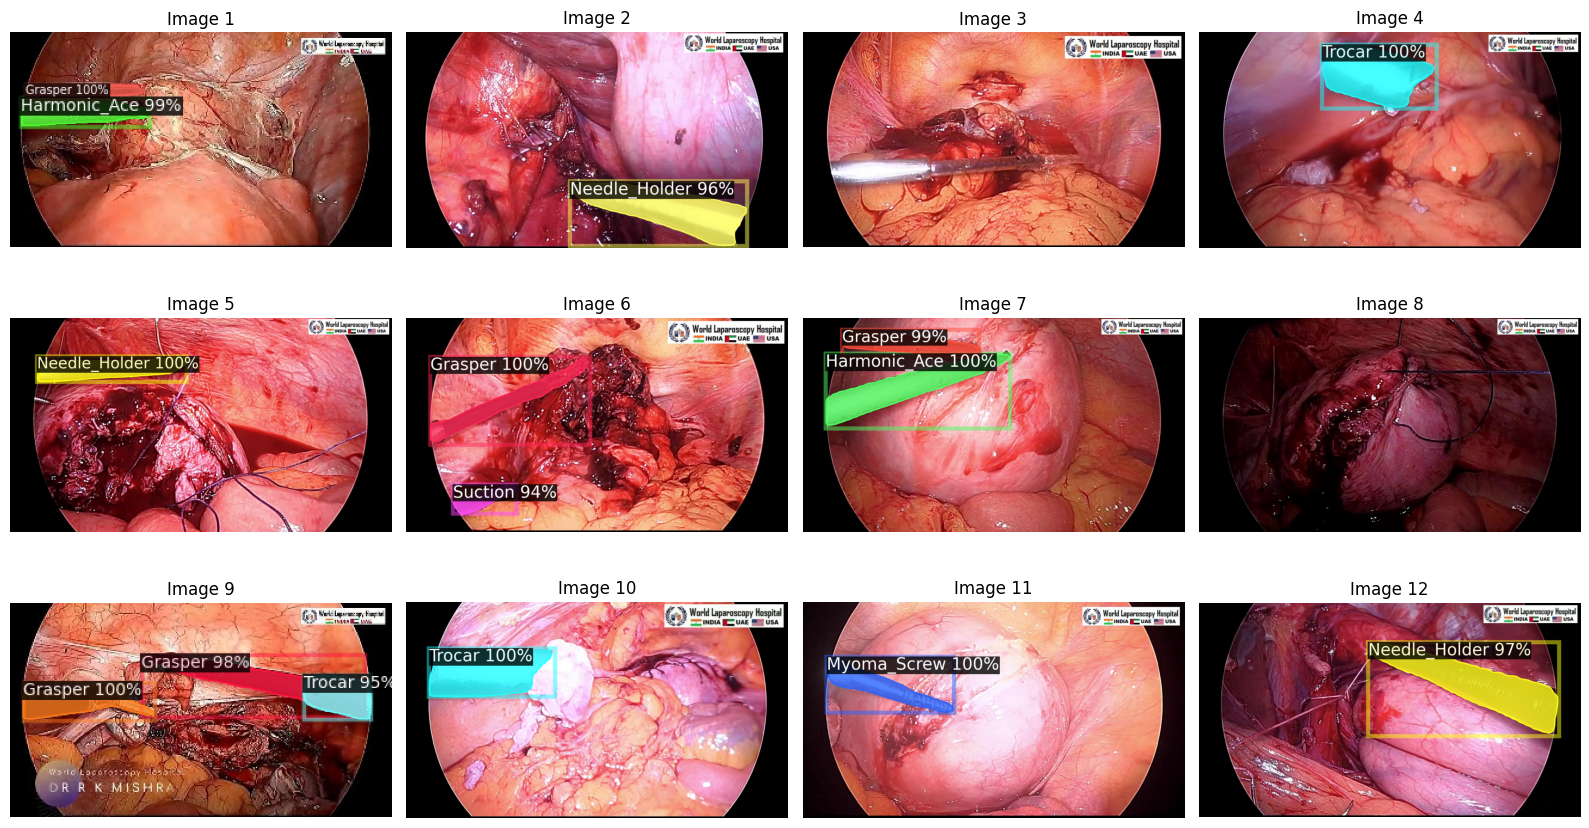

In [26]:
run_inference_on_random_images(12)